In [1]:
from itertools import islice
import multiprocessing

multiprocessing.set_start_method('fork')

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from networkx.classes.function import path_weight
from scipy.optimize import curve_fit

import tqdm

L = 10

# create grid with nn edges
G = nx.grid_2d_graph(L, L, periodic=True)

for e in G.edges():
    G[e[0]][e[1]]['weight'] = np.random.random()

In [2]:
def path_to_bit_rep(p, G):
    p = [(v, p[i+1]) for i, v in enumerate(p[:-1])]
    
    bit_rep = []
    for e in G.edges():
        if (e[0], e[1]) in p:
            bit_rep.append(1)
        else:
            bit_rep.append(0)
    
    return np.array(bit_rep)


def compute_dH(p0, p1, G):
    p0 = path_to_bit_rep(p0, G)
    p1 = path_to_bit_rep(p1, G)
    
    return np.abs(p0 - p1).sum()

In [3]:
def rows_delta(ns, n_rows):

    G = nx.grid_2d_graph(n_rows+1, ns+1)
    G = nx.DiGraph(G)
    for edge in G.copy().edges():
        if edge != tuple(sorted(edge)):
            G.remove_edge(*edge)

    source = (0, 0)
    target = (n_rows, ns)

    deltaM = np.zeros(M)
    dHM = np.zeros(M)

    for e in G.edges():
        G[e[0]][e[1]]['weight'] = np.random.random()

    p0, p1 = list(islice(nx.shortest_simple_paths(G, source, target, weight="weight"), 2))

    delta = path_weight(G, p1, weight="weight") - path_weight(G, p0, weight="weight")
    dH = compute_dH(p0, p1, G)

    return delta, dH

In [4]:
def sp_square_lattice(L):
    # create grid with nn edges
    G = nx.grid_2d_graph(L, L)

    source = (0, 0)
    target = (L-1, L-1)
    
    for e in G.edges():
        G[e[0]][e[1]]['weight'] = np.random.random()
        
    p0, p1 = list(islice(nx.shortest_simple_paths(G, source, target, weight="weight"), 2))
    delta = path_weight(G, p1, weight="weight") - path_weight(G, p0, weight="weight")
    dH = compute_dH(p0, p1, G)

    return delta, dH

In [5]:
%time sp_square_lattice(10)

CPU times: user 3.41 ms, sys: 114 µs, total: 3.53 ms
Wall time: 3.73 ms


(0.028567546579042258, 10)

In [6]:
deltas = np.load('delta.npy')

[ 1.69776025 -0.4383417 ]


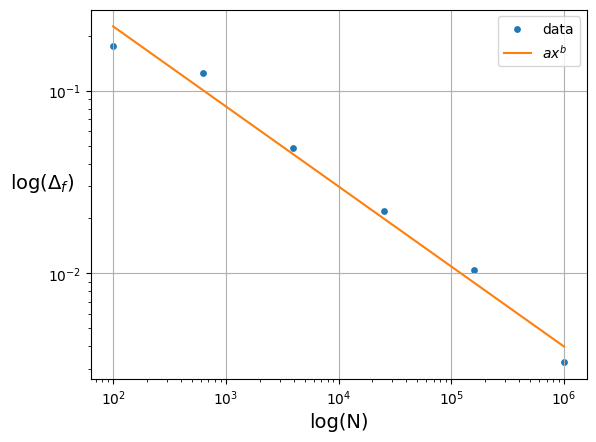

In [7]:
power_fit = lambda x, a, b: a * x**b

x = np.linspace(10, 1000)**2

plt.scatter(np.logspace(1, 3, 6)**2, deltas[:, 0], label='data', s=15)

popt, pcov = curve_fit(power_fit, np.logspace(1, 3, 6)**2, deltas[:, 0], p0=[1, -1], sigma=deltas[:, 1])
plt.plot(x, power_fit(x, *popt), label='$a x^b$ ', c='tab:orange')
print(popt)

plt.xlabel('log(N)', fontsize=14)
plt.ylabel('log($\\Delta_f$)', fontsize=14, rotation='horizontal')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.grid()

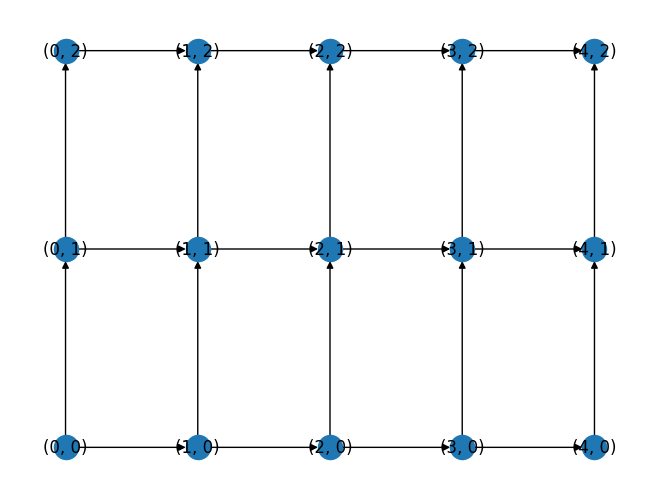

In [8]:
G = nx.grid_2d_graph(5, 3)

Gdir = nx.DiGraph(G)
for edge in Gdir.copy().edges():
    if edge != tuple(sorted(edge)):
        Gdir.remove_edge(*edge)
       
pos = dict(zip(Gdir, Gdir))
nx.draw(Gdir, pos=pos, with_labels=True)

plt.savefig("2rows_graph.pdf")

# Row Biased Graph

In [38]:
data = np.load("dRowBiased.npy")

Ns = data[0:27, 0]
delta = data[0:27, 1:3]
dH = data[0:27, 3:5]

[ 3.27202128e+01 -1.22488992e-04 -3.24565313e+01]
[ 3.31860360e+01 -6.42336438e-04 -3.29082690e+01]


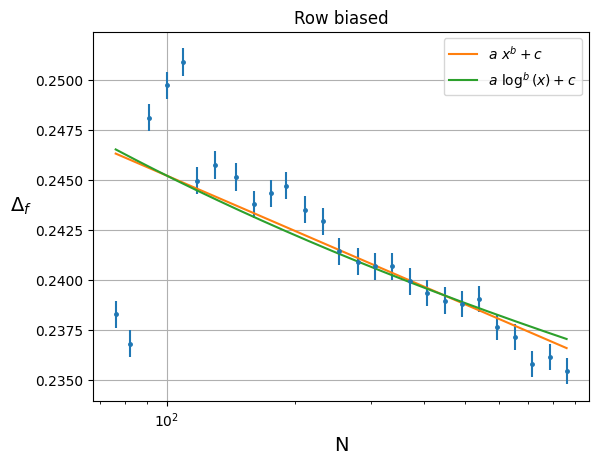

In [42]:
power_fit = lambda x, a, b, c: a * x**b + c
log_fit = lambda x, a, b, c: a * np.log(x)**b + c

N = [4 + 3*(ns - 1) for ns in Ns]

plt.errorbar(N, delta[:, 0], yerr=delta[:, 1], fmt='.', ms=5)

x = np.linspace(N[0], N[-1], 1000)

popt, pcov = curve_fit(power_fit, N, delta[:, 0], sigma=delta[:, 1], p0=[1., -0.7, 0.25], maxfev=10000)
plt.plot(x, power_fit(x, *popt), label='$a\ x^b + c$ ', c='tab:orange')
print(popt)

popt, pcov = curve_fit(log_fit, N, delta[:, 0], sigma=delta[:, 1], p0=[1., -1., 1], maxfev=10000)
plt.plot(x, log_fit(x, *popt), label='$a\ \\log^b(x) + c$', c='tab:green')
print(popt)

plt.xlabel('N', fontsize=14)
plt.ylabel('$\\Delta_f$    ', fontsize=14, rotation='horizontal')
plt.title("Row biased")
plt.legend()
plt.grid()

plt.xscale("log")
# plt.yscale("log")
plt.savefig("row_df.pdf")

[0.78635053 0.41213005 5.82032141]
[0.02037533 3.2653697  8.0793096 ]


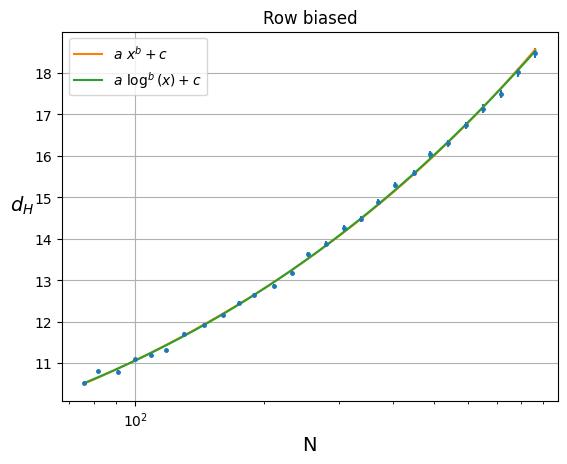

In [40]:
N = [4 + 3*(ns - 1) for ns in Ns]

plt.errorbar(N, dH[:, 0], yerr=dH[:, 1], fmt='.', ms=5)

dH[0, 1] = dH[1, 1]

x = np.linspace(N[0], N[-1], 1000)

popt, pcov = curve_fit(power_fit, N, dH[:, 0], sigma=dH[:, 1], maxfev=10000)
plt.plot(x, power_fit(x, *popt), label='$a\ x^b + c$ ', c='tab:orange')
print(popt)

popt, pcov = curve_fit(log_fit, N, dH[:, 0], sigma=dH[:, 1], maxfev=10000)
plt.plot(x, log_fit(x, *popt), label='$a\ \\log^b(x) + c$', c='tab:green')
print(popt)

plt.xlabel('N', fontsize=14)
plt.ylabel('$d_H$   ', fontsize=14, rotation='horizontal')
plt.title("Row biased")
plt.legend()
plt.grid()

plt.xscale("log")
plt.savefig("row_dH.pdf")

# Row unbiased graph

In [12]:
data = np.load("dRowUnbiased.npy")

Ns = data[:, 0]
delta = data[:, 1:3]
dH = data[:, 3:5]

[ 1.61364325 -0.6867188  -0.0103688 ]
[ 1.4788867  -1.67622635 -0.05657508]


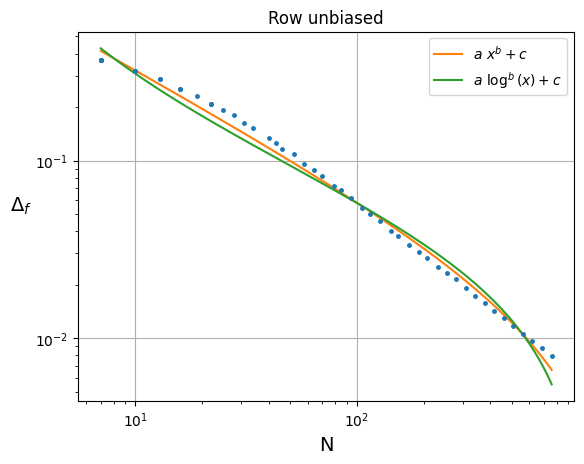

In [13]:
power_fit = lambda x, a, b, c: a * x**b + c
log_fit = lambda x, a, b, c: a * np.log(x)**b + c
nlog_fit = lambda x, a, b, c, d: a * x**b * np.log(x)**c + d

N = [4 + 3*(ns - 1) for ns in Ns]

plt.errorbar(N, delta[:, 0], yerr=delta[:, 1], fmt='.', ms=5)

x = np.linspace(N[0], N[-1], 1000)

popt, pcov = curve_fit(power_fit, N, delta[:, 0], sigma=delta[:, 1], p0=[0., -1., 0.], maxfev=100000)
plt.plot(x, power_fit(x, *popt), label='$a\ x^b + c$ ', c='tab:orange')
print(popt)

popt, pcov = curve_fit(log_fit, N, delta[:, 0], sigma=delta[:, 1], p0=[0, -1., 0.], maxfev=100000)
plt.plot(x, log_fit(x, *popt), label='$a\ \\log^b(x) + c$', c='tab:green')
print(popt)

# popt, pcov = curve_fit(nlog_fit, N, delta[:, 0], sigma=delta[:, 1], p0=[1., -0.5, -1., 0.], maxfev=100000)
# plt.plot(x, nlog_fit(x, *popt), label='$a\ x^b \\log^c(x) + d$', c='tab:red')
# print(popt)

plt.xlabel('N', fontsize=14)
plt.ylabel('$\\Delta_f$    ', fontsize=14, rotation='horizontal')
plt.title("Row unbiased")
plt.legend()
plt.grid()

plt.yscale('log')
plt.xscale('log')
plt.savefig("rowU_df.pdf")

/var/folders/5g/2335ntzx51d49vw09x7__6t40000gn/T/ipykernel_38278/2374918353.py:3: RuntimeWarning: overflow encountered in power
  power_fit = lambda x, a, b, c: a * (x)**b + c


[-10.30410947  -0.7894742    5.7894412 ]
[ 5.26396744e+03  2.75989821e-04 -5.26080793e+03]


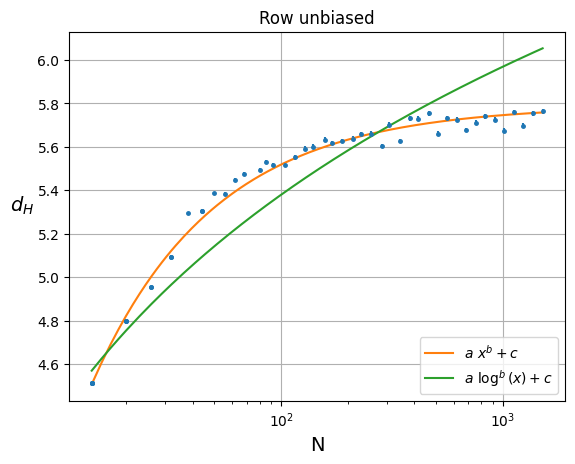

In [14]:
N = [2*(4 + 3*(ns - 1)) for ns in Ns]

power_fit = lambda x, a, b, c: a * (x)**b + c
log_fit = lambda x, a, b, c: a * np.log(x)**b + c
# nlog_fit = lambda x, a, b, c, d: a * x**b * np.log(x)**c + d

plt.errorbar(N, dH[:, 0], yerr=dH[:, 1], fmt='.', ms=5)

dH[0, 1] = dH[1, 1]

x = np.linspace(N[0], N[-1], 1000)

popt, pcov = curve_fit(power_fit, N, dH[:, 0], sigma=dH[:, 1], p0=[-1., -2., 7.], maxfev=1000000)
plt.plot(x, power_fit(x, *popt), label='$a\ x^b + c$', c='tab:orange')
print(popt)

popt, pcov = curve_fit(log_fit, N, dH[:, 0], sigma=dH[:, 1], maxfev=10000)
plt.plot(x, log_fit(x, *popt), label='$a\ \\log^b(x) + c$', c='tab:green')
print(popt)

# popt, pcov = curve_fit(nlog_fit, N, dH[:, 0], sigma=dH[:, 1], p0=[1., 0.5, 1., 0.], maxfev=10000)
# plt.plot(x, nlog_fit(x, *popt), label='$a\ x^b \\log^c(x) + d$', c='tab:red')
# print(popt)

plt.xlabel('N', fontsize=14)
plt.ylabel('$d_H$    ', fontsize=14, rotation='horizontal')
plt.title("Row unbiased")
plt.legend(loc='lower right')
plt.grid()

# plt.yscale('log')
plt.xscale('log')
plt.savefig("rowU_dH.pdf")

# 2 rows biased graph

In [15]:
data = np.load("d2RowBiased.npy")

Ns = data[:, 0]
delta = data[:, 1:3]
dH = data[:, 3:5]

[ 0.82234118 -0.67351664  0.1199788 ]
[ 0.86342125 -1.71255999  0.09487293]


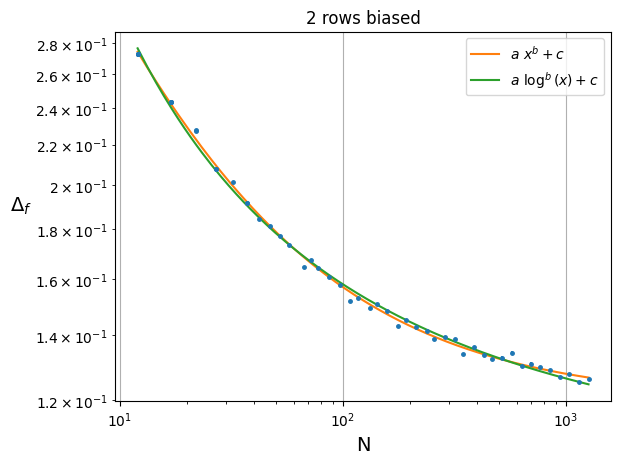

In [16]:
power_fit = lambda x, a, b, c: a * x**b + c
log_fit = lambda x, a, b, c: a * np.log(x)**b + c

N = [5*ns + 2 for ns in Ns]

plt.errorbar(N, delta[:, 0], yerr=delta[:, 1], fmt='.', ms=5)

x = np.linspace(N[0], N[-1], 1000)

popt, pcov = curve_fit(power_fit, N, delta[:, 0], sigma=delta[:, 1], p0=[1., -1., 0.], maxfev=10000)
plt.plot(x, power_fit(x, *popt), label='$a\ x^b + c$ ', c='tab:orange')
print(popt)

popt, pcov = curve_fit(log_fit, N, delta[:, 0], sigma=delta[:, 1], p0=[1., -1., 1], maxfev=10000)
plt.plot(x, log_fit(x, *popt), label='$a\ \\log^b(x) + c$', c='tab:green')
print(popt)

plt.xlabel('N', fontsize=14)
plt.ylabel('$\\Delta_f$    ', fontsize=14, rotation='horizontal')
plt.legend()
plt.grid()

plt.yscale('log')
plt.xscale('log')
plt.title("2 rows biased")
plt.savefig("2rows_df.pdf")

[0.5830165  0.52008684 2.91169583]
[0.03822055 3.20125438 4.35232969]


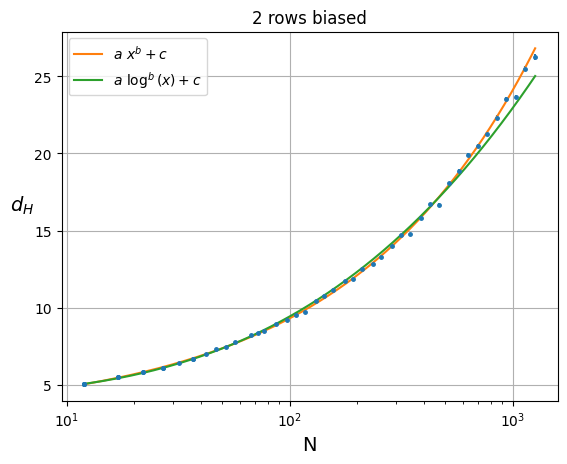

In [17]:
N = [5*ns + 2 for ns in Ns]

plt.errorbar(N, dH[:, 0], yerr=dH[:, 1], fmt='.', ms=5)

dH[0, 1] = dH[1, 1]

x = np.linspace(N[0], N[-1], 1000)

popt, pcov = curve_fit(power_fit, N, dH[:, 0], sigma=dH[:, 1], maxfev=10000)
plt.plot(x, power_fit(x, *popt), label='$a\ x^b + c$', c='tab:orange')
print(popt)

popt, pcov = curve_fit(log_fit, N, dH[:, 0], sigma=dH[:, 1], maxfev=10000)
plt.plot(x, log_fit(x, *popt), label='$a\ \\log^b(x) + c$', c='tab:green')
print(popt)

plt.xlabel('N', fontsize=14)
plt.ylabel('$d_H$   ', fontsize=14, rotation='horizontal')
plt.legend()
plt.grid()

# plt.yscale('log')
plt.xscale('log')
plt.title("2 rows biased")
plt.savefig("2rows_dH.pdf")

# 2 rows unbiased graph

In [18]:
data = np.load("d2RowUnbiased.npy")

Ns = data[:, 0]
delta = data[:, 1:3]
dH = data[:, 3:5]

[ 1.72996998 -0.68341191 -0.00806867]
[ 2.32739974 -2.06685362 -0.03566714]


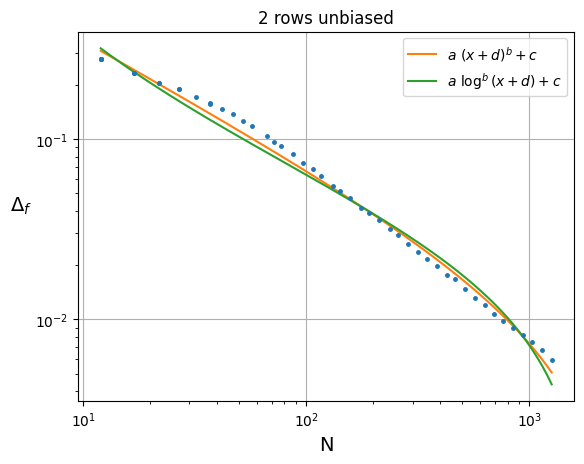

In [19]:
power_fit = lambda x, a, b, c: a * x**b + c
log_fit = lambda x, a, b, c: a * np.log(x)**b + c

N = [5*ns + 2 for ns in Ns]

plt.errorbar(N, delta[:, 0], yerr=delta[:, 1], fmt='.', ms=5)

x = np.linspace(N[0], N[-1], 1000)

popt, pcov = curve_fit(power_fit, N, delta[:, 0], sigma=delta[:, 1], p0=[0., -1., 0.], maxfev=10000)
plt.plot(x, power_fit(x, *popt), label='$a\ (x+d)^b + c$ ', c='tab:orange')
print(popt)

popt, pcov = curve_fit(log_fit, N, delta[:, 0], sigma=delta[:, 1], p0=[0, -1., -1.], maxfev=10000)
plt.plot(x, log_fit(x, *popt), label='$a\ \\log^b(x+d) + c$', c='tab:green')
print(popt)

plt.xlabel('N', fontsize=14)
plt.ylabel('$\\Delta_f$    ', fontsize=14, rotation='horizontal')
plt.legend()
plt.grid()

plt.yscale('log')
plt.xscale('log')
plt.title("2 rows unbiased")
plt.savefig("2rowsU_df.pdf")

[-12.3986439   -0.84320566   6.47043152]
[ 5.69939327e+03  2.91347111e-04 -5.69585902e+03]


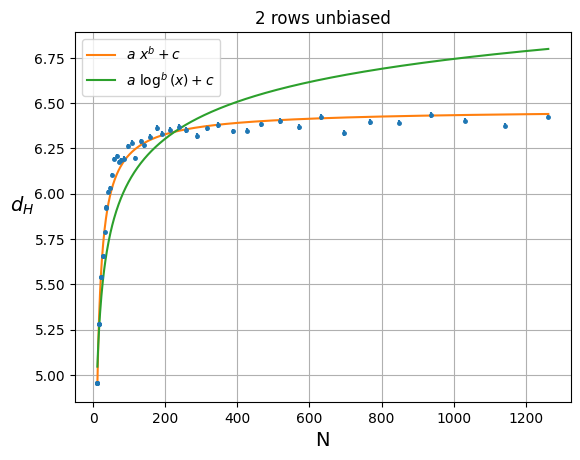

In [20]:
power_fit = lambda x, a, b, c: a * x**b + c
log_fit = lambda x, a, b, c: a * np.log(x)**b + c

N = [5*ns + 2 for ns in Ns]

plt.errorbar(N, dH[:, 0], yerr=dH[:, 1], fmt='.', ms=5)

dH[0, 1] = dH[1, 1]

x = np.linspace(N[0], N[-1], 1000)

popt, pcov = curve_fit(power_fit, N, dH[:, 0], sigma=dH[:, 1], p0=[-5., -2., 5], maxfev=10000)
plt.plot(x, power_fit(x, *popt), label='$a\ x^b + c$', c='tab:orange')
print(popt)

popt, pcov = curve_fit(log_fit, N, dH[:, 0], sigma=dH[:, 1], maxfev=10000)
plt.plot(x, log_fit(x, *popt), label='$a\ \\log^b(x) + c$', c='tab:green')
print(popt)

plt.xlabel('N', fontsize=14)
plt.ylabel('$d_H$   ', fontsize=14, rotation='horizontal')
plt.legend()
plt.grid()

# plt.xscale("log")
# plt.yscale("log")
plt.title("2 rows unbiased")
plt.savefig("2rowsU_dH.pdf")

# Square lattice biased graph

In [21]:
data = np.load("slBiased.npy")

Ls = data[:, 0]
delta = data[:, 1:3]
dH = data[:, 3:5]

In [22]:
power_fit = lambda x, a, b, c: a * x**b + c
log_fit = lambda x, a, b, c: a * np.log(x)**b + c

[ 8.45755245e-01 -4.47495638e-01 -5.94897602e-04]
[ 0.85897949 -1.13464197 -0.05626704]


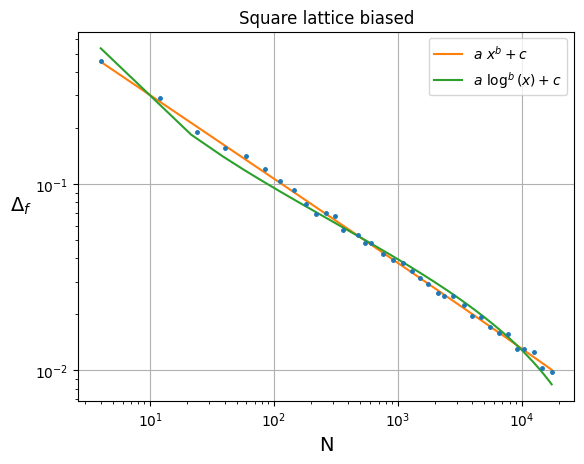

In [23]:
N = [2*L*(L+1) for L in Ls]

plt.errorbar(N, delta[:, 0], yerr=delta[:, 1], fmt='.', ms=5)

x = np.linspace(N[0], N[-1], 1000)

popt, pcov = curve_fit(power_fit, N, delta[:, 0], sigma=delta[:, 1], p0=[1., -1., 0], maxfev=10000)
plt.plot(x, power_fit(x, *popt), label='$a\ x^b + c$', c='tab:orange')
print(popt)

popt, pcov = curve_fit(log_fit, N, delta[:, 0], sigma=delta[:, 1], p0=[1., -1., 1], maxfev=10000)
plt.plot(x, log_fit(x, *popt), label='$a\ \\log^b(x) + c$', c='tab:green')
print(popt)

plt.xlabel('N', fontsize=14)
plt.ylabel('$\\Delta_f$    ', fontsize=14, rotation='horizontal')
plt.legend()
plt.grid()

plt.xscale("log")
plt.yscale("log")
plt.title("Square lattice biased")
plt.savefig("sl_df.pdf")

[ 1.37315924e+03  7.47351351e-04 -1.37060557e+03]
[1.00915135 1.00853532 2.57725615]


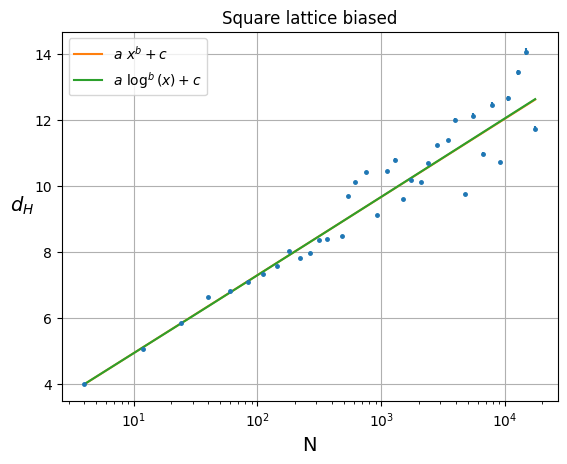

In [24]:
N = [2*L*(L+1) for L in Ls]

plt.errorbar(N, dH[:, 0], yerr=dH[:, 1], fmt='.', ms=5)

dH[0, 1] = dH[1, 1]

x = np.linspace(4, N[-1], 1000)

popt, pcov = curve_fit(power_fit, N, dH[:, 0], sigma=dH[:, 1], p0=[0.5, 0.5, 1], maxfev=10000)
plt.plot(x, power_fit(x, *popt), label='$a\ x^b + c$ ', c='tab:orange')
print(popt)

popt, pcov = curve_fit(log_fit, N, dH[:, 0], sigma=dH[:, 1], maxfev=10000)
plt.plot(x, log_fit(x, *popt), label='$a\ \\log^b(x) + c$', c='tab:green')
print(popt)

plt.xlabel('N', fontsize=14)
plt.ylabel('$d_H$   ', fontsize=14, rotation='horizontal')
plt.legend()
plt.grid()

plt.xscale("log")
# plt.yscale("log")
plt.title("Square lattice biased")
plt.savefig("sl_dH.pdf")

# Square lattice unbiased graph

In [25]:
data = np.load("slUnbiased.npy")

Ls = data[:, 0]
delta = data[:, 1:3]
dH = data[:, 3:5]

In [26]:
power_fit = lambda x, a, b, c: a * x**b + c
log_fit = lambda x, a, b, c: a * np.log(x)**b + c

[ 8.60212182e-01 -4.70917802e-01 -2.57116602e-04]
[ 0.83601981 -1.16777519 -0.05246961]


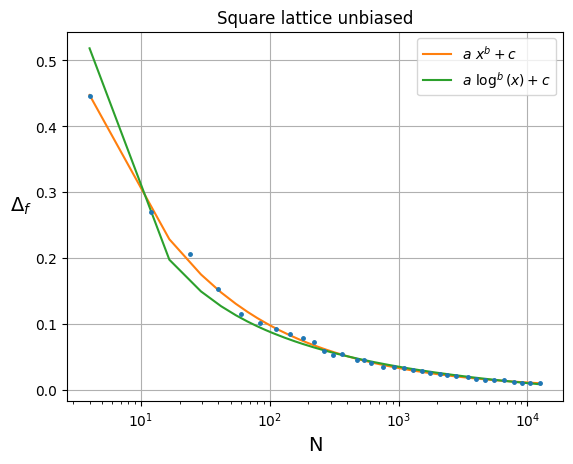

In [27]:
N = [2*L*(L+1) for L in Ls]

plt.errorbar(N, delta[:, 0], yerr=delta[:, 1], fmt='.', ms=5)

x = np.linspace(N[0], N[-1], 1000)

popt, pcov = curve_fit(power_fit, N, delta[:, 0], sigma=delta[:, 1], p0=[1., -1., 0], maxfev=10000)
plt.plot(x, power_fit(x, *popt), label='$a\ x^b + c$ ', c='tab:orange')
print(popt)

popt, pcov = curve_fit(log_fit, N, delta[:, 0], sigma=delta[:, 1], p0=[1., -1., 1], maxfev=10000)
plt.plot(x, log_fit(x, *popt), label='$a\ \\log^b(x) + c$', c='tab:green')
print(popt)

plt.xlabel('N', fontsize=14)
plt.ylabel('$\\Delta_f$    ', fontsize=14, rotation='horizontal')
plt.legend()
plt.grid()

# plt.yscale('log')
plt.xscale('log')
plt.title("Square lattice unbiased")
plt.savefig("slU_df.pdf")

[ 8.56763822e+03  1.08955811e-04 -8.56496119e+03]
[0.92974453 1.00192073 2.68226796]


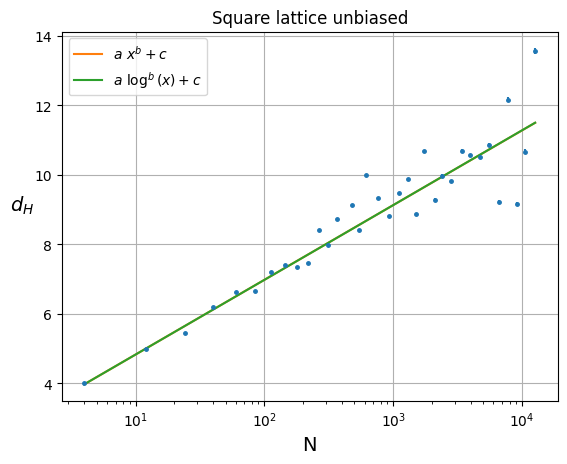

In [28]:
N = [2*L*(L+1) for L in Ls]

plt.errorbar(N, dH[:, 0], yerr=dH[:, 1], fmt='.', ms=5)

dH[0, 1] = dH[1, 1]

x = np.linspace(4, N[-1], 1000)

popt, pcov = curve_fit(power_fit, N, dH[:, 0], sigma=dH[:, 1], p0=[1, 1, 1], maxfev=10000)
plt.plot(x, power_fit(x, *popt), label='$a\ x^b + c$ ', c='tab:orange')
print(popt)

popt, pcov = curve_fit(log_fit, N, dH[:, 0], sigma=dH[:, 1], maxfev=10000)
plt.plot(x, log_fit(x, *popt), label='$a\ \\log^b(x) + c$', c='tab:green')
print(popt)

plt.xlabel('N', fontsize=14)
plt.ylabel('$d_H$   ', fontsize=14, rotation='horizontal')
plt.legend()
plt.grid()

plt.xscale('log')
plt.title("Square lattice unbiased")
plt.savefig("slU_dH.pdf")